# Load libraries and set device up

In [1]:
import numpy    as np
import torch.nn as nn
import os
import torch

import libraries.model   as clm
import libraries.dataset as cld

from torch_geometric.loader import DataLoader

# Checking if pytorch can run in GPU, else CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [2]:
target = 'bandgap'
folder = 'MP-bandgap'

target_folder = f'models/{folder}'

In [3]:
files_names = {
    'dataset_name':      f'{target_folder}/dataset.pt',
    'train_dt_std_name': f'{target_folder}/train_dataset_std.pt',
    'val_dt_std_name':   f'{target_folder}/val_dataset_std.pt',
    'test_dt_std_name':  f'{target_folder}/test_dataset_std.pt',
    'std_param_name':    f'{target_folder}/standardized_parameters.json',
    'dt_param_name':     f'{target_folder}/dataset_parameters.json',
    'uncert_data_name':  f'{target_folder}/uncertainty_data.json',
    'model_name':        f'{target_folder}/model.pt',
    'model_param_name':  f'{target_folder}/model_parameters.json'
}
cld.save_json(files_names, f'{target_folder}/files_names.json')

# Define parameters

In [4]:
n_epochs =      300
batch_size =    128
learning_rate = 0.001
dropout =       0.1
patience =      n_epochs
delta =         2
train_ratio =   0.8
test_ratio =    0.1  # val_ratio = 1 - train_ratio - test_ratio

model_parameters = {
    'n_epochs':      n_epochs,
    'batch_size':    batch_size,
    'learning_rate': learning_rate,
    'dropout':       dropout,
    'patience':      patience,
    'delta':         delta,
    'train_ratio':   train_ratio,
    'test_ratio':    test_ratio
}
cld.save_json(model_parameters, files_names['model_param_name'])

# Generate or load graph database for training

In [5]:
# Try loading the training datasets directly, else generate them
try:
    train_dataset, val_dataset, test_dataset, standardized_parameters = cld.load_datasets(files_names)

except FileNotFoundError:
    if not os.path.exists(files_names['dataset_name']):
        # Generate data
        cld.generate_dataset('datasets/bandgap-MChX',
                             targets=['bandgap'],
                             data_folder=target_folder)

    # Load the raw dataset, with corresponding labels, and standardize it
    dataset = torch.load(files_names['dataset_name'], weights_only=False)

    # Load dataset parameters
    dataset_parameters = cld.load_json(files_names['dt_param_name'])

    # Determine the index for the desired property
    target_idx = [idx for idx, t in enumerate(dataset_parameters['target']) if t == target][0]

    # Select the target we want
    for data in dataset:
        data.y = torch.tensor([data.y[target_idx]], dtype=torch.float)

    # Split datasets
    train_dataset, val_dataset, test_dataset = cld.split_dataset(train_ratio, test_ratio, dataset)
    del dataset  # Free up CUDA memory

    # Standardize train dataset
    train_dataset, standardized_parameters = cld.standardize_dataset(train_dataset)

    # Standardize test and validation datasets with train parameters
    val_dataset  = cld.standardize_dataset_from_keys(val_dataset,  standardized_parameters)
    test_dataset = cld.standardize_dataset_from_keys(test_dataset, standardized_parameters)

    # Save datasets
    cld.save_datasets(train_dataset, val_dataset, test_dataset, files_names)

    # Save standardized parameters
    cld.save_json(standardized_parameters, files_names['std_param_name'])

# Defining target factor
target_factor = np.array(standardized_parameters['target_std']) / standardized_parameters['scale']
targe_mean = standardized_parameters['target_mean']

Number of training   graphs: 35600
Number of validation graphs: 4450
Number of testing    graphs: 4450


Define data loaders.

In [6]:
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False, pin_memory=True)
val_loader   = DataLoader(val_dataset,   batch_size=batch_size, shuffle=False, pin_memory=True)
test_loader  = DataLoader(test_dataset,  batch_size=batch_size, shuffle=False, pin_memory=True)

# Determine number of node-level features in dataset, considering the t_step information
n_node_features = train_dataset[0].num_node_features

# Generate Graph Neural Network model

In [7]:
model = clm.load_model(n_node_features, dropout, device, model_name=files_names['model_name'], purpose='train')
model

DataParallel(
  (module): GCNN(
    (conv1): GraphConv(4, 32)
    (conv2): GraphConv(32, 32)
    (lin1): Linear(in_features=32, out_features=32, bias=True)
    (lin2): Linear(in_features=32, out_features=16, bias=True)
    (lin): Linear(in_features=16, out_features=1, bias=True)
  )
)

# Train

Define training optimized and criterion

In [8]:
# MSELoss is by default defined as the mean within the batch
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
criterion = torch.nn.MSELoss()

# Initialize early stopping
early_stopping = clm.EarlyStopping(patience=patience, delta=delta, model_name=files_names['model_name'])

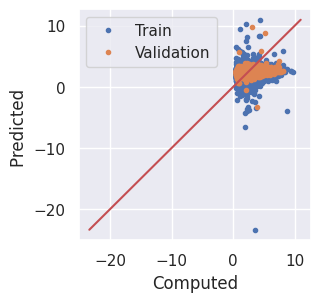

Epoch: 1, Train MAE: 1.4203, Val MAE: 1.3819
Epoch: 2, Train MAE: 1.3723, Val MAE: 1.3604
Epoch: 3, Train MAE: 1.3596, Val MAE: 1.3459
Epoch: 4, Train MAE: 1.3469, Val MAE: 1.3322
Epoch: 5, Train MAE: 1.3367, Val MAE: 1.3180
Epoch: 6, Train MAE: 1.3263, Val MAE: 1.3061
Epoch: 7, Train MAE: 1.3172, Val MAE: 1.2911
Epoch: 8, Train MAE: 1.3069, Val MAE: 1.2867
Epoch: 9, Train MAE: 1.2960, Val MAE: 1.2816
Epoch: 10, Train MAE: 1.2897, Val MAE: 1.2656


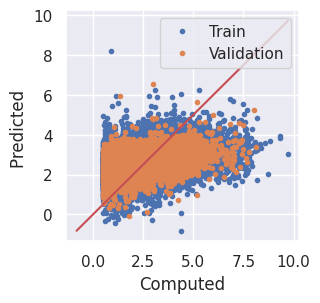

Epoch: 11, Train MAE: 1.2815, Val MAE: 1.2584
Epoch: 12, Train MAE: 1.2749, Val MAE: 1.2520
Epoch: 13, Train MAE: 1.2700, Val MAE: 1.2541
Epoch: 14, Train MAE: 1.2662, Val MAE: 1.2518
Epoch: 15, Train MAE: 1.2619, Val MAE: 1.2411
Epoch: 16, Train MAE: 1.2519, Val MAE: 1.2368
Epoch: 17, Train MAE: 1.2467, Val MAE: 1.2341
Epoch: 18, Train MAE: 1.2456, Val MAE: 1.2298
Epoch: 19, Train MAE: 1.2375, Val MAE: 1.2297
Epoch: 20, Train MAE: 1.2368, Val MAE: 1.2288


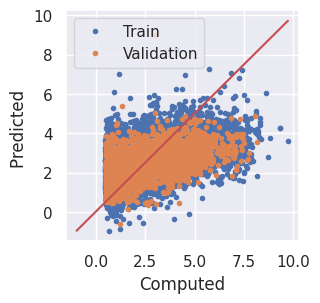

Epoch: 21, Train MAE: 1.2283, Val MAE: 1.2272
Epoch: 22, Train MAE: 1.2291, Val MAE: 1.2186
Epoch: 23, Train MAE: 1.2231, Val MAE: 1.2183
Epoch: 24, Train MAE: 1.2193, Val MAE: 1.2169
Epoch: 25, Train MAE: 1.2139, Val MAE: 1.2188
Epoch: 26, Train MAE: 1.2117, Val MAE: 1.2102
Epoch: 27, Train MAE: 1.2053, Val MAE: 1.2045
Epoch: 28, Train MAE: 1.1998, Val MAE: 1.2100
Epoch: 29, Train MAE: 1.2018, Val MAE: 1.2079
Epoch: 30, Train MAE: 1.2002, Val MAE: 1.2016


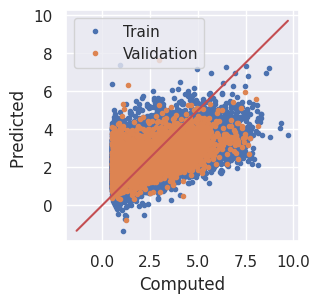

Epoch: 31, Train MAE: 1.1911, Val MAE: 1.2013
Epoch: 32, Train MAE: 1.1906, Val MAE: 1.1995
Epoch: 33, Train MAE: 1.1881, Val MAE: 1.1965
Epoch: 34, Train MAE: 1.1838, Val MAE: 1.1856
Epoch: 35, Train MAE: 1.1820, Val MAE: 1.1829
Epoch: 36, Train MAE: 1.1855, Val MAE: 1.1842
Epoch: 37, Train MAE: 1.1758, Val MAE: 1.1763
Epoch: 38, Train MAE: 1.1767, Val MAE: 1.1784
Epoch: 39, Train MAE: 1.1667, Val MAE: 1.1752
Epoch: 40, Train MAE: 1.1681, Val MAE: 1.1743


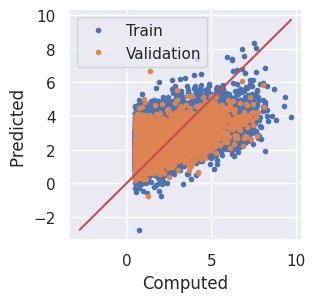

Epoch: 41, Train MAE: 1.1645, Val MAE: 1.1712
Epoch: 42, Train MAE: 1.1678, Val MAE: 1.1769
Epoch: 43, Train MAE: 1.1631, Val MAE: 1.1708
Epoch: 44, Train MAE: 1.1550, Val MAE: 1.1647
Epoch: 45, Train MAE: 1.1597, Val MAE: 1.1590
Epoch: 46, Train MAE: 1.1491, Val MAE: 1.1557
Epoch: 47, Train MAE: 1.1468, Val MAE: 1.1446
Epoch: 48, Train MAE: 1.1389, Val MAE: 1.1543
Epoch: 49, Train MAE: 1.1402, Val MAE: 1.1442
Epoch: 50, Train MAE: 1.1412, Val MAE: 1.1466


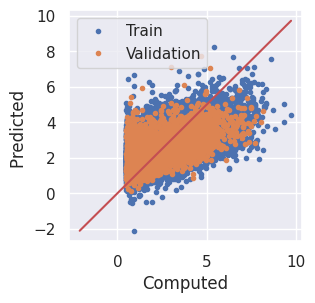

Epoch: 51, Train MAE: 1.1351, Val MAE: 1.1483
Epoch: 52, Train MAE: 1.1284, Val MAE: 1.1486
Epoch: 53, Train MAE: 1.1284, Val MAE: 1.1447
Epoch: 54, Train MAE: 1.1268, Val MAE: 1.1428
Epoch: 55, Train MAE: 1.1247, Val MAE: 1.1339
Epoch: 56, Train MAE: 1.1178, Val MAE: 1.1434
Epoch: 57, Train MAE: 1.1184, Val MAE: 1.1328
Epoch: 58, Train MAE: 1.1179, Val MAE: 1.1297
Epoch: 59, Train MAE: 1.1113, Val MAE: 1.1262
Epoch: 60, Train MAE: 1.1171, Val MAE: 1.1208


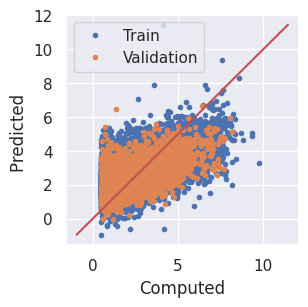

Epoch: 61, Train MAE: 1.1105, Val MAE: 1.1252
Epoch: 62, Train MAE: 1.1043, Val MAE: 1.1173
Epoch: 63, Train MAE: 1.1022, Val MAE: 1.1207
Epoch: 64, Train MAE: 1.0960, Val MAE: 1.1192
Epoch: 65, Train MAE: 1.0985, Val MAE: 1.1114
Epoch: 66, Train MAE: 1.0955, Val MAE: 1.1186
Epoch: 67, Train MAE: 1.0962, Val MAE: 1.1182
Epoch: 68, Train MAE: 1.0925, Val MAE: 1.1149
Epoch: 69, Train MAE: 1.0905, Val MAE: 1.1100
Epoch: 70, Train MAE: 1.0902, Val MAE: 1.1091


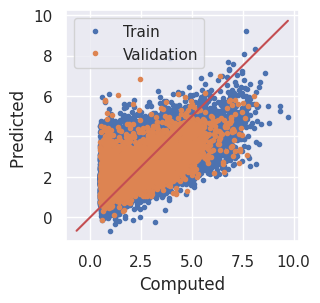

Epoch: 71, Train MAE: 1.0866, Val MAE: 1.1046
Epoch: 72, Train MAE: 1.0820, Val MAE: 1.1032
Epoch: 73, Train MAE: 1.0823, Val MAE: 1.1029
Epoch: 74, Train MAE: 1.0779, Val MAE: 1.1000
Epoch: 75, Train MAE: 1.0747, Val MAE: 1.0985
Epoch: 76, Train MAE: 1.0788, Val MAE: 1.1078
Epoch: 77, Train MAE: 1.0715, Val MAE: 1.0984
Epoch: 78, Train MAE: 1.0716, Val MAE: 1.1069
Epoch: 79, Train MAE: 1.0705, Val MAE: 1.0917
Epoch: 80, Train MAE: 1.0713, Val MAE: 1.0955


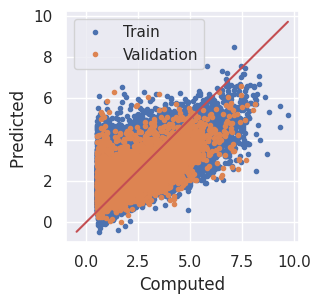

Epoch: 81, Train MAE: 1.0664, Val MAE: 1.0966
Epoch: 82, Train MAE: 1.0654, Val MAE: 1.0958
Epoch: 83, Train MAE: 1.0624, Val MAE: 1.0865
Epoch: 84, Train MAE: 1.0628, Val MAE: 1.0969
Epoch: 85, Train MAE: 1.0617, Val MAE: 1.0959
Epoch: 86, Train MAE: 1.0656, Val MAE: 1.0778
Epoch: 87, Train MAE: 1.0621, Val MAE: 1.0856
Epoch: 88, Train MAE: 1.0560, Val MAE: 1.0908
Epoch: 89, Train MAE: 1.0556, Val MAE: 1.0950
Epoch: 90, Train MAE: 1.0541, Val MAE: 1.0763


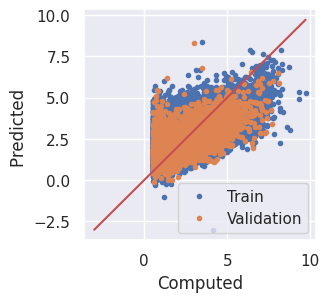

Epoch: 91, Train MAE: 1.0534, Val MAE: 1.0937
Epoch: 92, Train MAE: 1.0529, Val MAE: 1.0899
Epoch: 93, Train MAE: 1.0519, Val MAE: 1.1036
Epoch: 94, Train MAE: 1.0487, Val MAE: 1.0829
Epoch: 95, Train MAE: 1.0444, Val MAE: 1.0803
Epoch: 96, Train MAE: 1.0435, Val MAE: 1.0777
Epoch: 97, Train MAE: 1.0479, Val MAE: 1.0964
Epoch: 98, Train MAE: 1.0455, Val MAE: 1.0974
Epoch: 99, Train MAE: 1.0424, Val MAE: 1.0971
Epoch: 100, Train MAE: 1.0430, Val MAE: 1.0807


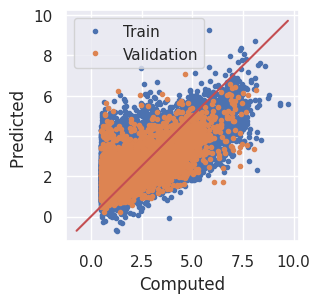

Epoch: 101, Train MAE: 1.0394, Val MAE: 1.0752
Epoch: 102, Train MAE: 1.0376, Val MAE: 1.0805
Epoch: 103, Train MAE: 1.0370, Val MAE: 1.0738
Epoch: 104, Train MAE: 1.0411, Val MAE: 1.0749
Epoch: 105, Train MAE: 1.0335, Val MAE: 1.0687
Epoch: 106, Train MAE: 1.0369, Val MAE: 1.0774
Epoch: 107, Train MAE: 1.0440, Val MAE: 1.0794
Epoch: 108, Train MAE: 1.0340, Val MAE: 1.0700
Epoch: 109, Train MAE: 1.0312, Val MAE: 1.0865
Epoch: 110, Train MAE: 1.0289, Val MAE: 1.0652


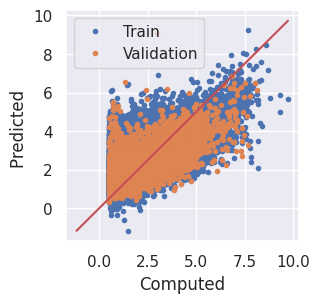

Epoch: 111, Train MAE: 1.0279, Val MAE: 1.0713
Epoch: 112, Train MAE: 1.0280, Val MAE: 1.0646
Epoch: 113, Train MAE: 1.0264, Val MAE: 1.0639
Epoch: 114, Train MAE: 1.0278, Val MAE: 1.0736
Epoch: 115, Train MAE: 1.0391, Val MAE: 1.0670
Epoch: 116, Train MAE: 1.0227, Val MAE: 1.0824
Epoch: 117, Train MAE: 1.0280, Val MAE: 1.0667
Epoch: 118, Train MAE: 1.0221, Val MAE: 1.0723
Epoch: 119, Train MAE: 1.0218, Val MAE: 1.0709
Epoch: 120, Train MAE: 1.0230, Val MAE: 1.0664


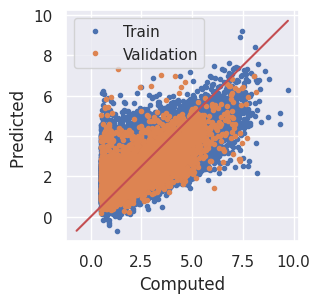

Epoch: 121, Train MAE: 1.0216, Val MAE: 1.0647
Epoch: 122, Train MAE: 1.0211, Val MAE: 1.0611
Epoch: 123, Train MAE: 1.0204, Val MAE: 1.0626
Epoch: 124, Train MAE: 1.0192, Val MAE: 1.0706
Epoch: 125, Train MAE: 1.0189, Val MAE: 1.0635
Epoch: 126, Train MAE: 1.0230, Val MAE: 1.0631
Epoch: 127, Train MAE: 1.0181, Val MAE: 1.0581
Epoch: 128, Train MAE: 1.0170, Val MAE: 1.0736
Epoch: 129, Train MAE: 1.0176, Val MAE: 1.0720
Epoch: 130, Train MAE: 1.0156, Val MAE: 1.0745


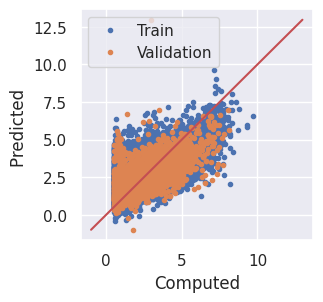

Epoch: 131, Train MAE: 1.0124, Val MAE: 1.0649
Epoch: 132, Train MAE: 1.0171, Val MAE: 1.0540
Epoch: 133, Train MAE: 1.0185, Val MAE: 1.0612
Epoch: 134, Train MAE: 1.0117, Val MAE: 1.0524
Epoch: 135, Train MAE: 1.0143, Val MAE: 1.0630
Epoch: 136, Train MAE: 1.0094, Val MAE: 1.0629
Epoch: 137, Train MAE: 1.0077, Val MAE: 1.0556
Epoch: 138, Train MAE: 1.0171, Val MAE: 1.0553
Epoch: 139, Train MAE: 1.0103, Val MAE: 1.0510
Epoch: 140, Train MAE: 1.0081, Val MAE: 1.0608


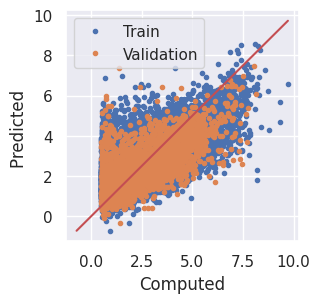

Epoch: 141, Train MAE: 1.0150, Val MAE: 1.0592
Epoch: 142, Train MAE: 1.0081, Val MAE: 1.0557
Epoch: 143, Train MAE: 1.0065, Val MAE: 1.0477
Epoch: 144, Train MAE: 1.0046, Val MAE: 1.0518
Epoch: 145, Train MAE: 1.0105, Val MAE: 1.0602
Epoch: 146, Train MAE: 1.0062, Val MAE: 1.0589
Epoch: 147, Train MAE: 1.0079, Val MAE: 1.0666
Epoch: 148, Train MAE: 1.0044, Val MAE: 1.0553
Epoch: 149, Train MAE: 1.0027, Val MAE: 1.0506
Epoch: 150, Train MAE: 1.0015, Val MAE: 1.0533


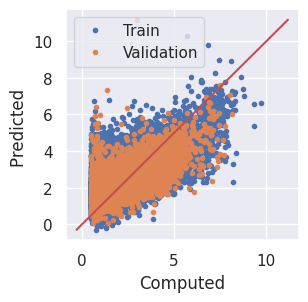

Epoch: 151, Train MAE: 1.0034, Val MAE: 1.0539
Epoch: 152, Train MAE: 1.0026, Val MAE: 1.0646
Epoch: 153, Train MAE: 1.0003, Val MAE: 1.0546
Epoch: 154, Train MAE: 1.0068, Val MAE: 1.0589
Epoch: 155, Train MAE: 0.9963, Val MAE: 1.0561
Epoch: 156, Train MAE: 1.0084, Val MAE: 1.0488
Epoch: 157, Train MAE: 0.9996, Val MAE: 1.0645
Epoch: 158, Train MAE: 1.0034, Val MAE: 1.0464
Epoch: 159, Train MAE: 0.9963, Val MAE: 1.0465
Epoch: 160, Train MAE: 0.9999, Val MAE: 1.0626


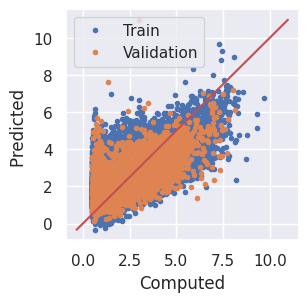

Epoch: 161, Train MAE: 0.9993, Val MAE: 1.0547
Epoch: 162, Train MAE: 1.0019, Val MAE: 1.0591
Epoch: 163, Train MAE: 0.9978, Val MAE: 1.0513
Epoch: 164, Train MAE: 0.9940, Val MAE: 1.0607
Epoch: 165, Train MAE: 1.0045, Val MAE: 1.0442
Epoch: 166, Train MAE: 0.9960, Val MAE: 1.0516
Epoch: 167, Train MAE: 0.9949, Val MAE: 1.0721
Epoch: 168, Train MAE: 0.9957, Val MAE: 1.0555
Epoch: 169, Train MAE: 0.9956, Val MAE: 1.0636
Epoch: 170, Train MAE: 0.9945, Val MAE: 1.0542


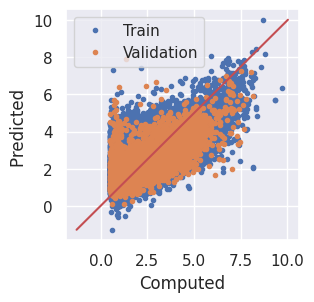

Epoch: 171, Train MAE: 0.9896, Val MAE: 1.0392
Epoch: 172, Train MAE: 0.9932, Val MAE: 1.0454
Epoch: 173, Train MAE: 0.9990, Val MAE: 1.0483
Epoch: 174, Train MAE: 0.9918, Val MAE: 1.0403
Epoch: 175, Train MAE: 0.9922, Val MAE: 1.0460
Epoch: 176, Train MAE: 0.9880, Val MAE: 1.0444
Epoch: 177, Train MAE: 0.9884, Val MAE: 1.0412
Epoch: 178, Train MAE: 0.9902, Val MAE: 1.0628
Epoch: 179, Train MAE: 0.9924, Val MAE: 1.0450
Epoch: 180, Train MAE: 0.9887, Val MAE: 1.0628


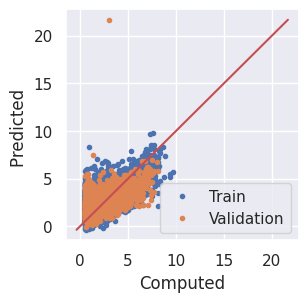

Epoch: 181, Train MAE: 0.9914, Val MAE: 1.0762
Epoch: 182, Train MAE: 0.9951, Val MAE: 1.0439
Epoch: 183, Train MAE: 0.9879, Val MAE: 1.0400
Epoch: 184, Train MAE: 0.9883, Val MAE: 1.0369
Epoch: 185, Train MAE: 0.9894, Val MAE: 1.0487
Epoch: 186, Train MAE: 0.9870, Val MAE: 1.0507
Epoch: 187, Train MAE: 0.9849, Val MAE: 1.0603
Epoch: 188, Train MAE: 0.9809, Val MAE: 1.0526
Epoch: 189, Train MAE: 0.9845, Val MAE: 1.0418
Epoch: 190, Train MAE: 0.9859, Val MAE: 1.0469


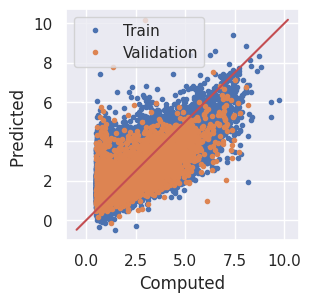

Epoch: 191, Train MAE: 0.9832, Val MAE: 1.0407
Epoch: 192, Train MAE: 0.9833, Val MAE: 1.0459
Epoch: 193, Train MAE: 1.0075, Val MAE: 1.0363
Epoch: 194, Train MAE: 0.9832, Val MAE: 1.0359
Epoch: 195, Train MAE: 0.9808, Val MAE: 1.0331
Epoch: 196, Train MAE: 0.9830, Val MAE: 1.0465
Epoch: 197, Train MAE: 0.9770, Val MAE: 1.0291
Epoch: 198, Train MAE: 0.9820, Val MAE: 1.0318
Epoch: 199, Train MAE: 0.9798, Val MAE: 1.0426
Epoch: 200, Train MAE: 0.9809, Val MAE: 1.0235


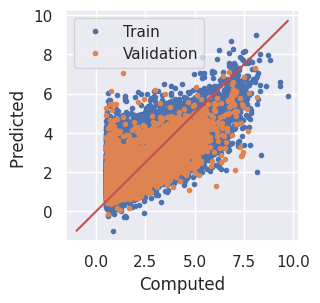

Epoch: 201, Train MAE: 0.9757, Val MAE: 1.0313
Epoch: 202, Train MAE: 0.9799, Val MAE: 1.0381
Epoch: 203, Train MAE: 0.9834, Val MAE: 1.0340
Epoch: 204, Train MAE: 0.9791, Val MAE: 1.0358
Epoch: 205, Train MAE: 0.9814, Val MAE: 1.0273
Epoch: 206, Train MAE: 0.9783, Val MAE: 1.0301
Epoch: 207, Train MAE: 0.9761, Val MAE: 1.0287
Epoch: 208, Train MAE: 0.9773, Val MAE: 1.0291
Epoch: 209, Train MAE: 0.9801, Val MAE: 1.0281
Epoch: 210, Train MAE: 0.9970, Val MAE: 1.0382


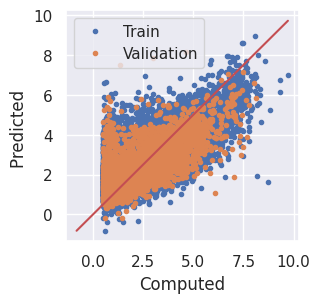

Epoch: 211, Train MAE: 0.9783, Val MAE: 1.0295
Epoch: 212, Train MAE: 0.9754, Val MAE: 1.0304
Epoch: 213, Train MAE: 0.9737, Val MAE: 1.0157
Epoch: 214, Train MAE: 0.9749, Val MAE: 1.0198
Epoch: 215, Train MAE: 0.9736, Val MAE: 1.0183
Epoch: 216, Train MAE: 0.9773, Val MAE: 1.0303
Epoch: 217, Train MAE: 0.9749, Val MAE: 1.0288
Epoch: 218, Train MAE: 0.9776, Val MAE: 1.0318
Epoch: 219, Train MAE: 0.9751, Val MAE: 1.0194
Epoch: 220, Train MAE: 0.9771, Val MAE: 1.0282


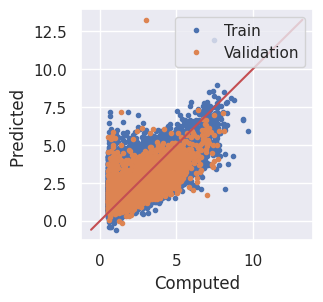

Epoch: 221, Train MAE: 0.9751, Val MAE: 1.0350
Epoch: 222, Train MAE: 0.9678, Val MAE: 1.0296
Epoch: 223, Train MAE: 0.9696, Val MAE: 1.0247
Epoch: 224, Train MAE: 0.9713, Val MAE: 1.0248
Epoch: 225, Train MAE: 0.9760, Val MAE: 1.0264
Epoch: 226, Train MAE: 0.9705, Val MAE: 1.0232
Epoch: 227, Train MAE: 0.9709, Val MAE: 1.0184
Epoch: 228, Train MAE: 0.9724, Val MAE: 1.0349
Epoch: 229, Train MAE: 0.9787, Val MAE: 1.0349
Epoch: 230, Train MAE: 0.9759, Val MAE: 1.0175


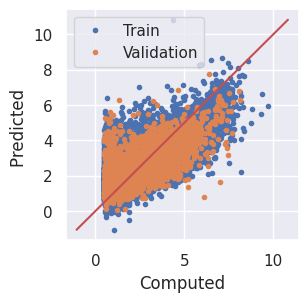

Epoch: 231, Train MAE: 0.9738, Val MAE: 1.0153
Epoch: 232, Train MAE: 0.9677, Val MAE: 1.0232
Epoch: 233, Train MAE: 0.9717, Val MAE: 1.0192
Epoch: 234, Train MAE: 0.9690, Val MAE: 1.0341
Epoch: 235, Train MAE: 0.9781, Val MAE: 1.0277
Epoch: 236, Train MAE: 0.9638, Val MAE: 1.0304
Epoch: 237, Train MAE: 0.9692, Val MAE: 1.0162
Epoch: 238, Train MAE: 0.9651, Val MAE: 1.0233
Epoch: 239, Train MAE: 0.9684, Val MAE: 1.0256
Epoch: 240, Train MAE: 0.9679, Val MAE: 1.0201


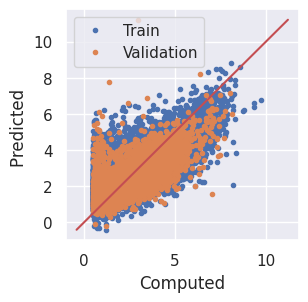

Epoch: 241, Train MAE: 0.9642, Val MAE: 1.0197
Epoch: 242, Train MAE: 0.9692, Val MAE: 1.0300
Epoch: 243, Train MAE: 0.9726, Val MAE: 1.0234
Epoch: 244, Train MAE: 0.9648, Val MAE: 1.0174
Epoch: 245, Train MAE: 0.9642, Val MAE: 1.0151
Epoch: 246, Train MAE: 0.9664, Val MAE: 1.0246
Epoch: 247, Train MAE: 0.9659, Val MAE: 1.0245
Epoch: 248, Train MAE: 0.9621, Val MAE: 1.0228
Epoch: 249, Train MAE: 0.9629, Val MAE: 1.0171
Epoch: 250, Train MAE: 0.9627, Val MAE: 1.0295


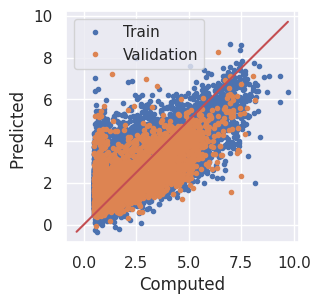

Epoch: 251, Train MAE: 0.9677, Val MAE: 1.0184
Epoch: 252, Train MAE: 0.9698, Val MAE: 1.0177
Epoch: 253, Train MAE: 0.9660, Val MAE: 1.0628
Epoch: 254, Train MAE: 0.9753, Val MAE: 1.0300
Epoch: 255, Train MAE: 0.9627, Val MAE: 1.0228
Epoch: 256, Train MAE: 0.9630, Val MAE: 1.0256
Epoch: 257, Train MAE: 0.9638, Val MAE: 1.0200
Epoch: 258, Train MAE: 0.9602, Val MAE: 1.0146
Epoch: 259, Train MAE: 0.9597, Val MAE: 1.0142
Epoch: 260, Train MAE: 0.9621, Val MAE: 1.0243


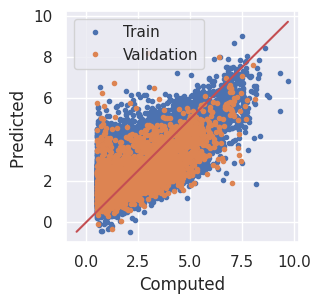

Epoch: 261, Train MAE: 0.9573, Val MAE: 1.0129
Epoch: 262, Train MAE: 0.9609, Val MAE: 1.0269
Epoch: 263, Train MAE: 0.9642, Val MAE: 1.0167
Epoch: 264, Train MAE: 0.9620, Val MAE: 1.0149
Epoch: 265, Train MAE: 0.9561, Val MAE: 1.0077
Epoch: 266, Train MAE: 0.9603, Val MAE: 1.0108
Epoch: 267, Train MAE: 0.9640, Val MAE: 1.0101
Epoch: 268, Train MAE: 0.9619, Val MAE: 1.0244
Epoch: 269, Train MAE: 0.9578, Val MAE: 1.0184
Epoch: 270, Train MAE: 0.9664, Val MAE: 1.0187


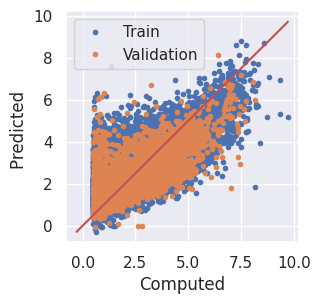

Epoch: 271, Train MAE: 0.9577, Val MAE: 1.0073
Epoch: 272, Train MAE: 0.9676, Val MAE: 1.0233
Epoch: 273, Train MAE: 0.9662, Val MAE: 1.0243
Epoch: 274, Train MAE: 0.9596, Val MAE: 1.0125
Epoch: 275, Train MAE: 0.9612, Val MAE: 1.0272
Epoch: 276, Train MAE: 0.9565, Val MAE: 1.0106
Epoch: 277, Train MAE: 0.9536, Val MAE: 1.0141
Epoch: 278, Train MAE: 0.9534, Val MAE: 1.0137
Epoch: 279, Train MAE: 0.9547, Val MAE: 1.0199
Epoch: 280, Train MAE: 0.9546, Val MAE: 1.0095


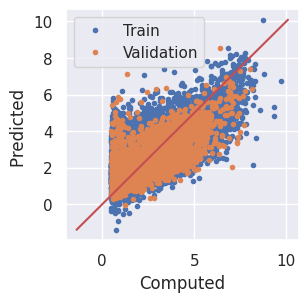

Epoch: 281, Train MAE: 0.9605, Val MAE: 1.0159
Epoch: 282, Train MAE: 0.9701, Val MAE: 1.0137
Epoch: 283, Train MAE: 0.9603, Val MAE: 1.0077
Epoch: 284, Train MAE: 0.9558, Val MAE: 1.0424
Epoch: 285, Train MAE: 0.9545, Val MAE: 1.0184
Epoch: 286, Train MAE: 0.9581, Val MAE: 1.0134
Epoch: 287, Train MAE: 0.9515, Val MAE: 1.0135
Epoch: 288, Train MAE: 0.9591, Val MAE: 1.0067
Epoch: 289, Train MAE: 0.9654, Val MAE: 1.0009
Epoch: 290, Train MAE: 0.9565, Val MAE: 1.0300


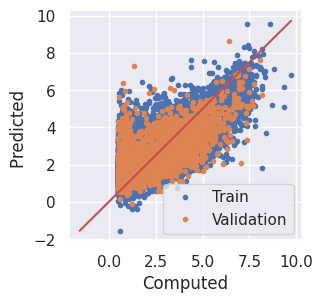

Epoch: 291, Train MAE: 0.9542, Val MAE: 1.0070
Epoch: 292, Train MAE: 0.9538, Val MAE: 1.0135
Epoch: 293, Train MAE: 0.9564, Val MAE: 1.0038
Epoch: 294, Train MAE: 0.9558, Val MAE: 1.0123
Epoch: 295, Train MAE: 0.9541, Val MAE: 1.0128
Epoch: 296, Train MAE: 0.9551, Val MAE: 1.0188
Epoch: 297, Train MAE: 0.9528, Val MAE: 1.0189
Epoch: 298, Train MAE: 0.9569, Val MAE: 1.0083
Epoch: 299, Train MAE: 0.9579, Val MAE: 1.0118
Epoch: 300, Train MAE: 0.9525, Val MAE: 1.0198


In [9]:
# Train the model
train_losses = []
val_losses   = []
for epoch in np.arange(0, n_epochs):
    train_loss, train_predictions, train_ground_truths = clm.train(model, criterion, train_loader,
                                                                   target_factor,
                                                                   standardized_parameters['target_mean'],
                                                                   optimizer)
    val_loss,   val_predictions,   val_ground_truths   =  clm.test(model, criterion, val_loader,
                                                                   target_factor,
                                                                   standardized_parameters['target_mean'])

    # Convert to original units
    train_loss = np.sum(np.sqrt(train_loss) * target_factor)
    val_loss   = np.sum(np.sqrt(val_loss)   * target_factor)

    if epoch%10 == 0:
        cld.parity_plot(train=np.array([train_ground_truths, train_predictions]),
                        validation=np.array([val_ground_truths, val_predictions]))
    
    # Append losses
    train_losses.append(train_loss)
    val_losses.append(val_loss)

    # Check early stopping criteria
    early_stopping(val_loss, model)

    if early_stopping.early_stop:
        print('Early stopping')
        break

    print(f'Epoch: {epoch+1}, Train MAE: {train_loss:.4f}, Val MAE: {val_loss:.4f}')

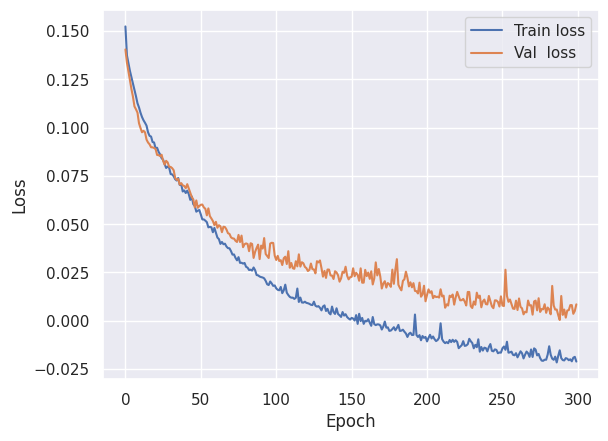

In [10]:
cld.losses_plot(train_losses=train_losses,
                val_losses=val_losses,
                to_log=True)

# Check test data

In [11]:
model = clm.load_model(n_node_features, dropout, device, model_name=files_names['model_name'], purpose='eval')
model

DataParallel(
  (module): GCNN(
    (conv1): GraphConv(4, 32)
    (conv2): GraphConv(32, 32)
    (lin1): Linear(in_features=32, out_features=32, bias=True)
    (lin2): Linear(in_features=32, out_features=16, bias=True)
    (lin): Linear(in_features=16, out_features=1, bias=True)
  )
)

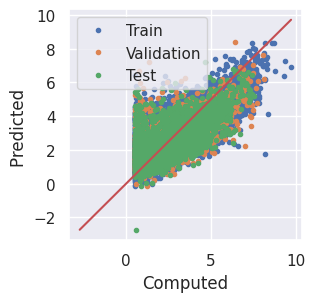

Train MAE: 0.9149, Val MAE: 1.0009, Test MAE: 0.9817


In [12]:
train_loss, train_predictions, train_ground_truths = clm.test(model, criterion, train_loader,
                                                              target_factor,
                                                              standardized_parameters['target_mean'])
val_loss,   val_predictions,   val_ground_truths   =  clm.test(model, criterion, val_loader,
                                                               target_factor,
                                                               standardized_parameters['target_mean'])
test_loss,  test_predictions,  test_ground_truths  =  clm.test(model, criterion, test_loader,
                                                               target_factor,
                                                               standardized_parameters['target_mean'])

# Pass to energy units (same as initial Fv)
train_loss = np.sum(np.sqrt(train_loss) * target_factor)
val_loss   = np.sum(np.sqrt(val_loss)   * target_factor)
test_loss  = np.sum(np.sqrt(test_loss)  * target_factor)

cld.parity_plot(train=np.array([train_ground_truths, train_predictions]),
                validation=np.array([val_ground_truths, val_predictions]),
                test=np.array([test_ground_truths, test_predictions]),
                save_to=f'{target_folder}/{target}-GCNN-training.pdf')

print(f'Train MAE: {train_loss:.4f}, Val MAE: {val_loss:.4f}, Test MAE: {test_loss:.4f}')

# Generate uncertainties and save

In [13]:
dataset = [data for dataset in [train_dataset, val_dataset, test_dataset] for data in dataset]

loader = DataLoader(dataset, batch_size=batch_size, shuffle=False, pin_memory=True)

loss, predictions, ground_truths = clm.test(model, criterion, loader,
                                            target_factor,
                                            standardized_parameters['target_mean'])

# label: uncertainty = ground-truth - prediction
uncertainties = ground_truths - predictions

# Standardize for better interpolation
uncertainties_std = (uncertainties - standardized_parameters['target_mean']) * standardized_parameters['scale'] / standardized_parameters['target_std']

# Generate dictionary with uncertainty data
uncertainty_data = {}
for idx in range(len(dataset)):
    uncertainty_data.update(
        {dataset[idx].label: float(uncertainties_std[idx])}
    )

# Dump the dictionary with numpy arrays to a JSON file
cld.save_json(uncertainty_data, files_names['uncert_data_name'])